**Introduction**

The purpose of this project is to cluster wines based on chemical features like alcohol content and acidity. We will attempt to identify the true number of clusters in the dataset and compare our clustering results with the ground truth labels.

[Github link](https://github.com/JackShell1/Wine-Clustering)

**Exploratory Data Analysis**

We will begin by loading the wine data from [UCI](https://archive.ics.uci.edu/dataset/109/wine). We will inspect the features and perform some basic visualization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wine = pd.read_csv('/content/wine.data', header=None, names=['ID','Alcohol', 'Malic Acid', 'Ash',
                                                             'Alcalinity', 'Magnesium', 'Total Phenols',
                                                             'Flavanoids', 'Nonflav phenols', 'Proanthocyanins',
                                                             'Color', 'Hue', 'OD280/OD315', 'Proline'])

In [3]:
wine.head()

ID  Alcohol  Malic Acid   Ash  Alcalinity  Magnesium  Total Phenols  \
0   1    14.23        1.71  2.43        15.6        127           2.80   
1   1    13.20        1.78  2.14        11.2        100           2.65   
2   1    13.16        2.36  2.67        18.6        101           2.80   
3   1    14.37        1.95  2.50        16.8        113           3.85   
4   1    13.24        2.59  2.87        21.0        118           2.80   

   Flavanoids  Nonflav phenols  Proanthocyanins  Color   Hue  OD280/OD315  \
0        3.06             0.28             2.29   5.64  1.04         3.92   
1        2.76             0.26             1.28   4.38  1.05         3.40   
2        3.24             0.30             2.81   5.68  1.03         3.17   
3        3.49             0.24             2.18   7.80  0.86         3.45   
4        2.69             0.39             1.82   4.32  1.04         2.93   

   Proline  
0     1065  
1     1050  
2     1185  
3     1480  
4      735

In [4]:
features = np.shape(wine)[1]
length = len(wine)
print(f'Number of Observations: {length}\n'
      f'Number of Features: {features}')

Number of Observations: 178
Number of Features: 14


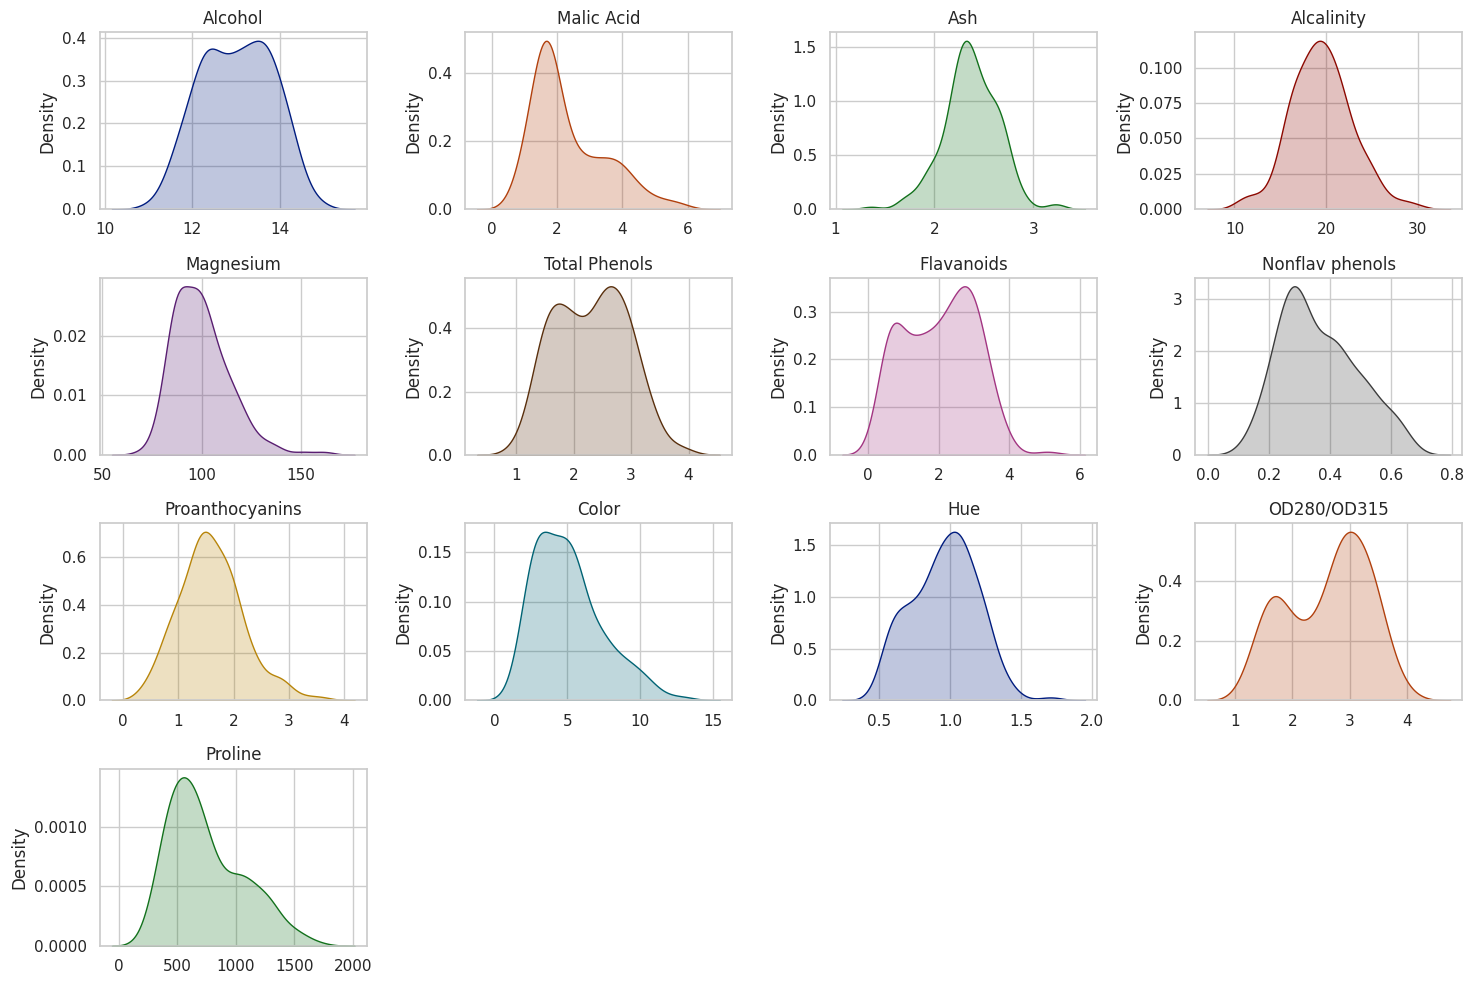

In [7]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))
palette = sns.color_palette("dark", 13)

for index, column in enumerate(wine.drop('ID', axis=1).columns):
    plt.subplot(4, 4, index + 1)
    sns.kdeplot(wine[column], color=palette[index], fill=True)
    plt.title(column)
    plt.xlabel('')
    plt.tight_layout()

plt.show()

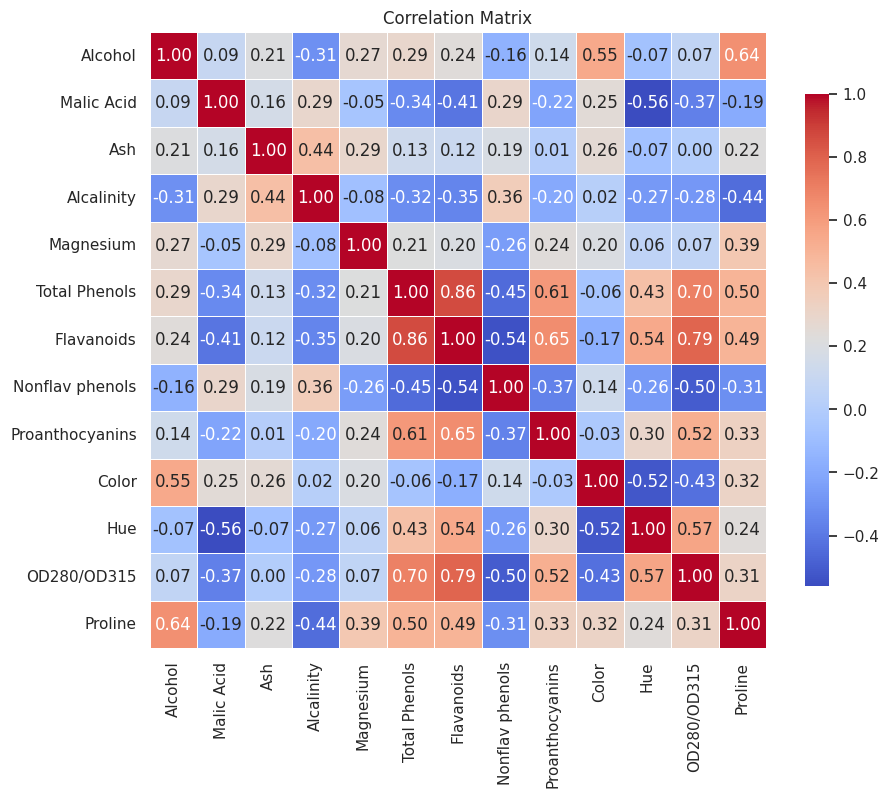

In [8]:
corr = wine.drop('ID', axis=1).corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix')

plt.show()

**Model Building and Training**

We will train a K-means model to attempt to determine the true number of clusters in our dataset. We will observe how the within and between cluster sums of squares change as we increase the number of clusters.

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

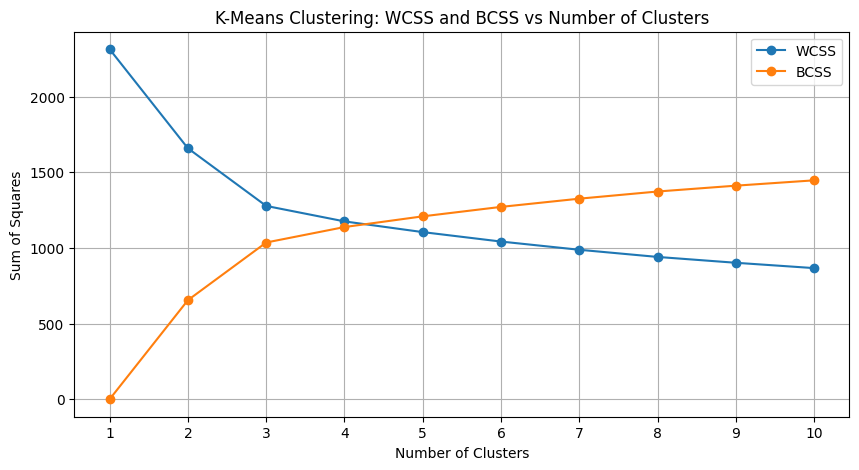

In [6]:
import warnings
warnings.filterwarnings('ignore')
wine1 = wine.drop(['ID'], axis=1, errors='ignore')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(wine1)

clusters = range(1, 11)
wcss = []
bcss = []

total_mean = scaled_data.mean(axis=0)
TSS = ((scaled_data - total_mean)**2).sum()

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
    bcss.append(TSS - kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(clusters, wcss, label='WCSS', marker='o')
plt.plot(clusters, bcss, label='BCSS', marker='o')
plt.title('K-Means Clustering: WCSS and BCSS vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares')
plt.xticks(clusters)
plt.legend()
plt.grid(True)
plt.show()

From this, it seems approariate to use k=3 clusters, as the rate of change in the explained variance decreases dramatically beyond k=3.

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42)
pred = kmeans.fit_predict(scaled_data)

In [8]:
import itertools
wine2 = wine.copy()
wine2['pclass'] = pred
elements = wine2['ID'].unique().tolist()
maps = list(itertools.permutations(range(1,4)))
best_map, best_score = None, 0
for map in maps:
  key = {i:j for i,j in enumerate(map)}
  wine2['pred'] = wine2['pclass'].map(key)
  score = (wine2['ID'] == wine2['pred']).sum() / len(wine2)
  if score > best_score:
    best_map, best_score = map, score
best_key = {i:j for i,j in enumerate(best_map)}
wine2['pred'] = wine2['pclass'].map(best_key)
print(f'Training accuracy: {best_score}')

Training accuracy: 0.9662921348314607


**Comparison to Supervised Learning**

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(wine.drop('ID', axis=1), wine['ID'], test_size=0.2)

In [50]:
kernels = ['linear', 'poly', 'rbf']
C = [0.1, 1.0, 10]
best_score = 0
best_c, best_k = None, None
for k in kernels:
  for c in C:
    svc = SVC(kernel=k, C=c).fit(X_train, y_train)
    pred = svc.predict(X_test)
    y_test = pd.DataFrame(y_test)
    y_test['pred'] = pred
    acc = (y_test['pred'] == y_test['ID']).sum() / len(y_test)
    if acc > best_score:
      best_score, best_c, best_k = acc, c, k
print(f'SVC Accuracy: {best_score}\n'
      f'Best Params: C = {best_c}, Kernel = {best_k}')

SVC Accuracy: 0.9444444444444444
Best Params: C = 0.1, Kernel = linear


Our model was able to achieve a 98% accuracy on the training set. Below we can view a pairplot of the features with our predicted clusters. In reality, the wines in the data set were from three different cultivars, so k=3 was the correct choice. Overall, our k-means approach was able to identify the true clusters in the data with a high degree of accuracy. Furthermore, our clustering approach performed better than a hyperparamter-optimized support vector classifier.

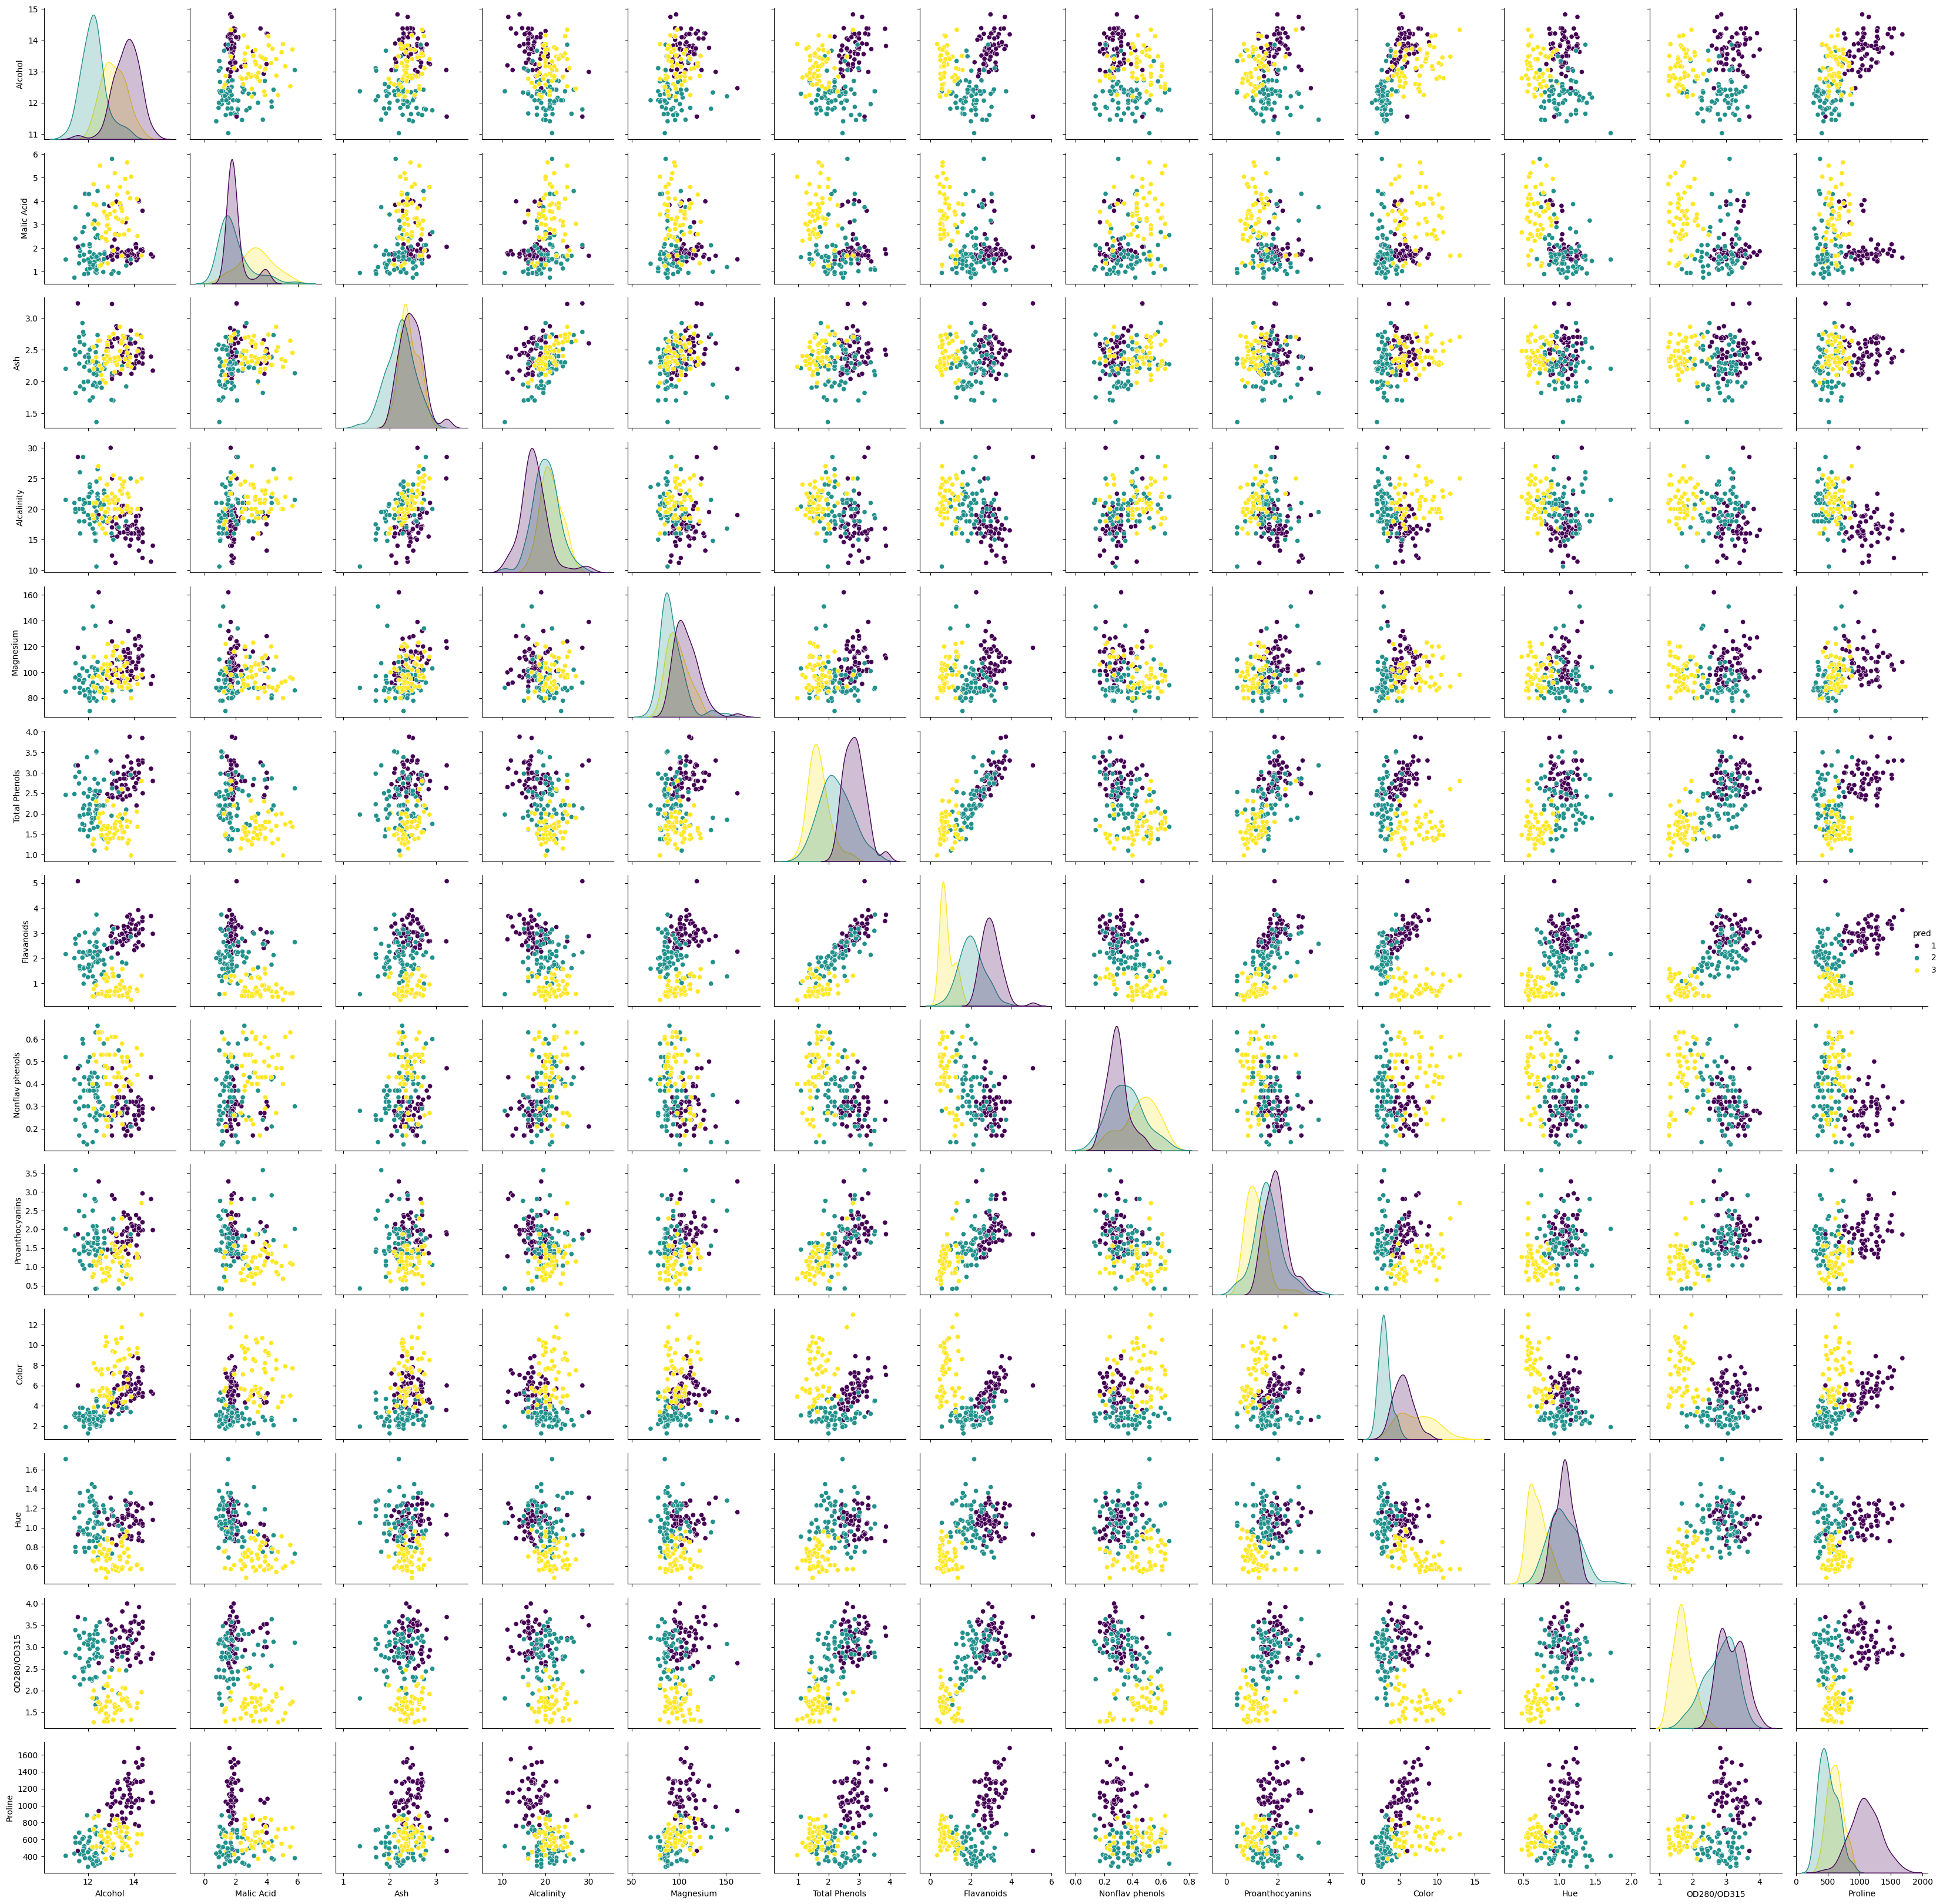

In [12]:
plot_data = wine2.drop(['ID', 'pred', 'pclass'], axis=1, errors='ignore')

pair_plot = sns.pairplot(data=wine2, hue='pred', vars=plot_data.columns, palette='viridis')

plt.tight_layout()

plt.show()